In [1]:
# import time libraries
import time
from datetime import datetime
from time import gmtime, strftime

# Set Begin Time to Measure Time to Run of Whole Notebook
begin_time = time.time()

### Package Update / References
* Below is a List of Conda Commands to Run to Install / Update Relavent Packages.
* Also I Included Links to Some Kernels I Found Useful.

In [2]:
# conda install -c conda-forge/label/gcc7 eli5
# conda install -c anaconda py-xgboost
# conda install -c conda-forge matplotlib
# conda install -c conda-forge seaborn

# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
# https://www.kaggle.com/dgawlik/house-prices-eda

## Import Libraries and Set Options

In [3]:
## Pull Relavent Libraries

# Standard Libraries
import pandas as pd
import numpy as np
import os
import math
import requests
from io import StringIO
import sys
import os.path
from IPython.display import display, HTML

# For Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# For Building Histograms
from scipy.stats import norm
import matplotlib.mlab as mlab
import scipy.stats as st
import scipy.stats
from scipy import stats

# Other
from scipy.stats import norm, skew #for some statistics
from scipy.special import boxcox1p

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

### Pull Train and Test Datasets from Github

In [4]:
# Remote Data File
url_test = 'https://raw.githubusercontent.com/armandpost/HousePriceRegression/master/Data/test.csv'
url_train = 'https://raw.githubusercontent.com/armandpost/HousePriceRegression/master/Data/train.csv'

s_test = requests.get(url_test).text
s_train = requests.get(url_train).text

df_test = pd.read_csv(StringIO(s_test),low_memory = False)
df_train = pd.read_csv(StringIO(s_train),low_memory = False)
df_test['segment'] = 'test'
df_train['segment'] = 'train'
df = pd.concat([df_test, df_train], ignore_index = True, sort = False)

pd.set_option('display.max_colwidth', -1)

display(HTML(df[0:5].to_html()))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,segment,SalePrice
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,CBlock,TA,TA,No,Rec,468.000,LwQ,144.000,270.000,882.000,GasA,TA,Y,SBrkr,896,0,0,896,0.000,0.000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.000,Unf,1.000,730.000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,test,nan
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000,TA,TA,CBlock,TA,TA,No,ALQ,923.000,Unf,0.000,406.000,1329.000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000,0.000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.000,Unf,1.000,312.000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,test,nan
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,GLQ,791.000,Unf,0.000,137.000,928.000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.000,0.000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000,Fin,2.000,482.000,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,test,nan
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000,TA,TA,PConc,TA,TA,No,GLQ,602.000,Unf,0.000,324.000,926.000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.000,0.000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000,Fin,2.000,470.000,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,test,nan
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.000,Gd,TA,PConc,Gd,TA,No,ALQ,263.000,Unf,0.000,1017.000,1280.000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.000,0.000,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.000,RFn,2.000,506.000,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,test,nan


### Convert All Float or Integer Types to INT32

In [5]:
ColumnList = df.columns.tolist()

for i in range(0,len(ColumnList)):
    if df[ColumnList[i]].dtype == 'object':
        df[ColumnList[i]] = df[ColumnList[i]]
    elif df[ColumnList[i]].dtype == 'float32':
        df[ColumnList[i]] = int(df[ColumnList[i]])
    elif df[ColumnList[i]].dtype == 'float64':
        df[ColumnList[i]] = df[ColumnList[i]].fillna(0).astype(np.int32)
    elif df[ColumnList[i]].dtype == 'int64':
        df[ColumnList[i]] = df[ColumnList[i]].fillna(0).astype(np.int32)
    elif df_all[ColumnList[i]].dtype == 'uint8':
        df_all[ColumnList[i]] = df_all[ColumnList[i]].fillna(0).astype(np.int32)
    else:
        df[ColumnList[i]] = df[ColumnList[i]]

### Create Functions

In [6]:
### Create a Function to Build Histograms

def histogram(variable, name, color, bins):
    
    totalVals = variable.count
    missings = variable.isnull().sum(axis = 0).sum()
    variable2 = variable.dropna()
   
    # best fit of data
    (mu, sigma) = norm.fit(variable2)

    # the histogram of the data
    n, bins, patches = plt.hist(variable2, bins, density = True, facecolor = color, alpha = 0.75)
    
    # add a 'best fit' line
    y = scipy.stats.norm.pdf(bins, mu, sigma)
    l = plt.plot(bins, y, 'r--', linewidth = 2)

    #plot
    plt.xlabel(name + ': Missings = ' + str(missings))
    plt.ylabel('Probability')
    plt.title(r'$\mathrm{Histogram\ of\ ' + name + ':}\ \mu =%.3f,\ \sigma =%.3f$' %(mu, sigma))
    plt.grid(True)

    plt.show()

### Create Function for Barplots
  
def countplotshorizontal(frame, field, title, ylabel, palette):
    frame[field] = pd.Categorical(frame[field])
    g = sns.countplot(y = field, data = frame, order = frame[field].value_counts().index, palette = palette)
    g.set_ylabel(ylabel)
    g.set_title(title)
    plt.show()
    
### Create Function for Boxplots

def boxplot(x, y, **kwargs):
    sns.boxplot(x = x, y = y)
    x = plt.xticks(rotation = 90)
    
### Create Function Using Anova to Quickly Estimate Impact of Categorical Variables on Target

def anova(frame, List, target):
    anv = pd.DataFrame()
    anv['feature'] = List
    pvals = []
    for c in List:
        samples = []
        for cls in df[c].unique():
            s = df[df[c] == cls][target].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

### Create Functions to Quickly Assess the Correlation of Variables to the Target

def encode(frame, feature, target):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, target]].groupby(feature).mean()[target]
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature + '_E'] = o
    
def spearman(frame, features, target):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame[target], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25 * len(features)))
    sns.barplot(data = spr, y = 'feature', x = 'spearman', orient = 'h')

## Create Lists of Variable Types to Assist with Transformations

In [7]:
ContinuousList = ['LotFrontage','LotArea','OverallQual','OverallCond','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                  'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath',
                  'HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF',
                  'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','SalePrice']

CategoricalList = ['MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood',
                   'Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
                   'MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                   'BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
                   'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence',
                   'MiscFeature','SaleType','SaleCondition']

DeltaList = ['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']

BandedList = ['MSSubClass','MoSold']

#### Create Bands

In [8]:
MSSubClass_bins = [-1, 20, 50, 80, 999]
MSSubClass_names = ['lt_20', 'lt_50', 'lt_80', 'gt_80']
df['MSSubClass_band'] = pd.cut(df['MSSubClass'], MSSubClass_bins, labels = MSSubClass_names)

MoSold_bins = [-1, 3, 6, 9, 99]
MoSold_names = ['Q1', 'Q2', 'Q3', 'Q4']
df['MoSold_band'] = pd.cut(df['MoSold'], MoSold_bins, labels = MoSold_names)

CategoricalList.extend(['MSSubClass_band','MoSold_band'])

In [9]:
pd.options.display.float_format = '{:,.2f}'.format
display(HTML(df.filter(DeltaList, axis = 1).describe(percentiles = [.01,.05,.10,.25,.50,.75,.90,.95,.99]).to_html()))

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,"2,919.00","2,919.00","2,919.00","2,919.00"
mean,"1,971.31","1,984.26","1,870.36","2,007.79"
std,30.29,20.89,449.69,1.31
min,"1,872.00","1,950.00",0.00,"2,006.00"
1%,"1,900.00","1,950.00",0.00,"2,006.00"
5%,"1,915.00","1,950.00",0.00,"2,006.00"
10%,"1,924.00","1,950.00","1,927.00","2,006.00"
25%,"1,953.50","1,965.00","1,957.00","2,007.00"
50%,"1,973.00","1,993.00","1,977.00","2,008.00"
75%,"2,001.00","2,004.00","2,001.00","2,009.00"


#### Convert Years to Linear Data and Add Total Square Feet

In [10]:
for i in range(0,len(DeltaList)):
    df[DeltaList[i]] = np.where(df[DeltaList[i]] == 0, np.nan, df[DeltaList[i]])
    df[DeltaList[i]] = np.where(df[DeltaList[i]] > 2010, 2010, df[DeltaList[i]])
    df[DeltaList[i]] = 2010 - df[DeltaList[i]]
    
# Adding total sq footage
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

ContinuousList.extend(['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','TotalSF'])

In [11]:
pd.options.display.float_format = '{:,.2f}'.format
display(HTML(df.filter(DeltaList, axis = 1).describe(percentiles = [.01,.05,.10,.25,.50,.75,.90,.95,.99]).to_html()))

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,"2,919.00","2,919.00","2,760.00","2,919.00"
mean,38.69,25.74,31.96,2.21
std,30.29,20.89,25.21,1.31
min,0.00,0.00,0.00,0.00
1%,2.00,1.00,1.00,0.00
5%,3.00,3.00,3.00,0.00
10%,4.00,3.80,4.00,0.00
25%,9.00,6.00,8.00,1.00
50%,37.00,17.00,31.00,2.00
75%,56.50,45.00,50.00,3.00


#### Fill Categorical NAs with "None" and Create Bar Charts

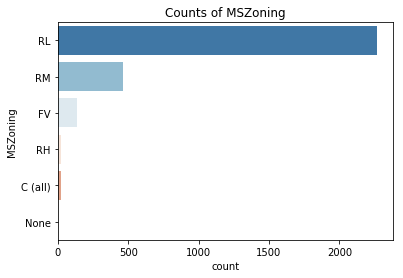

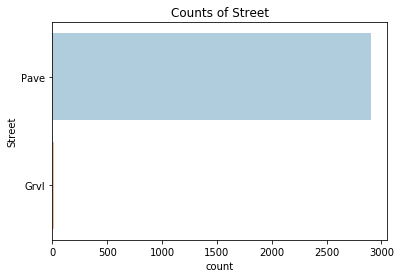

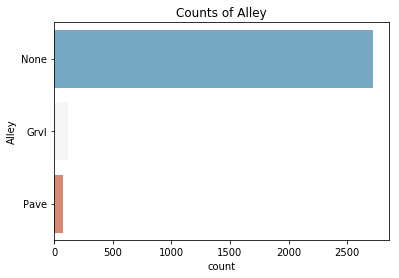

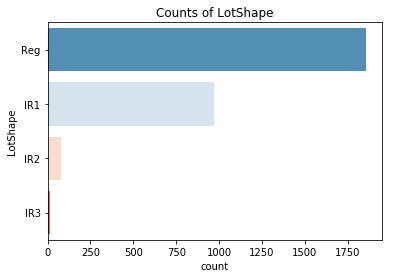

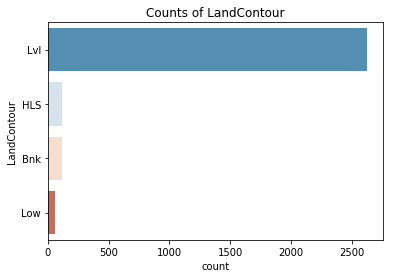

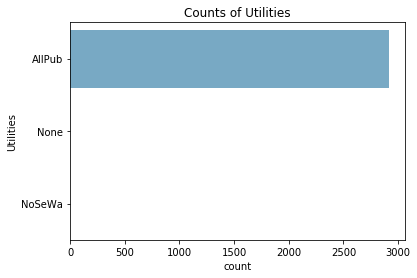

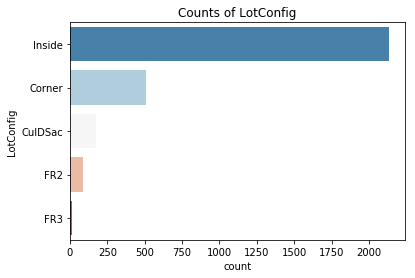

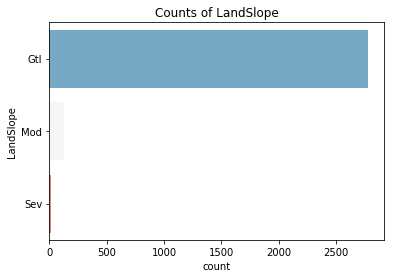

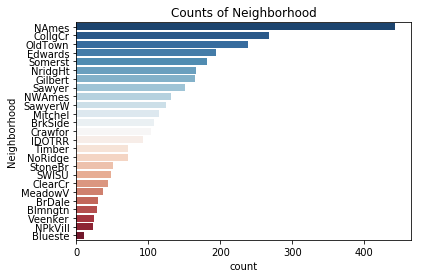

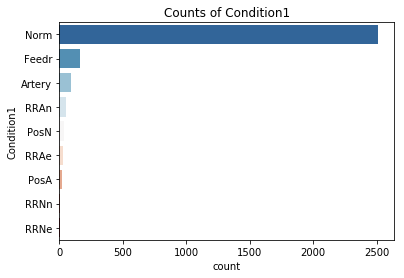

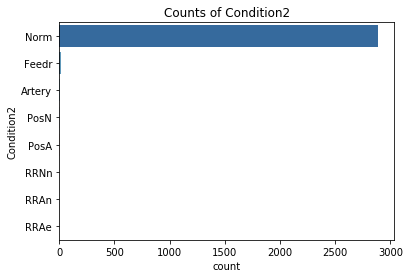

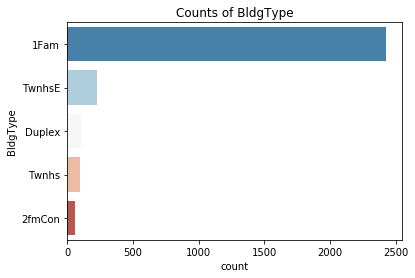

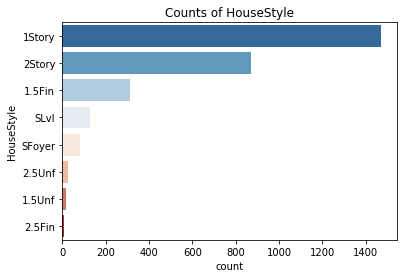

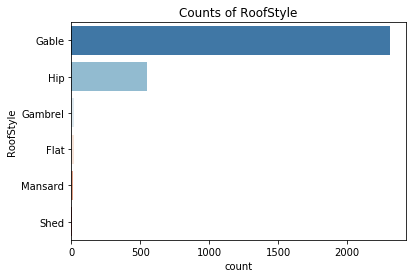

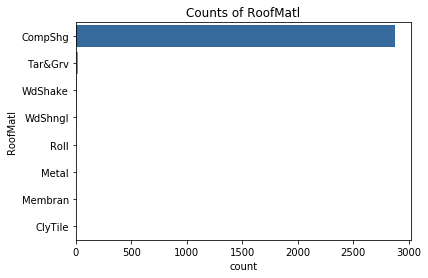

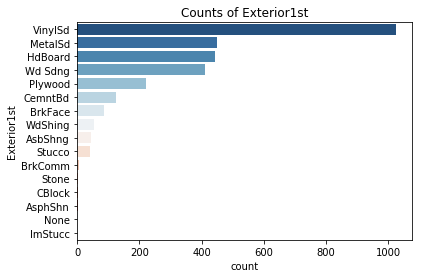

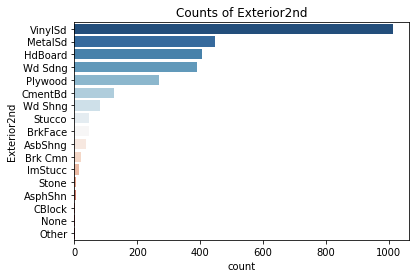

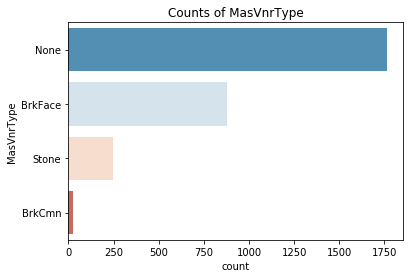

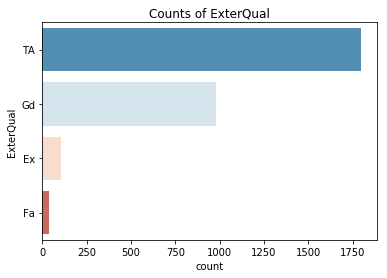

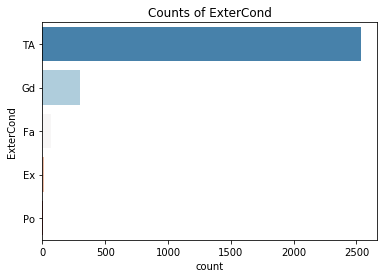

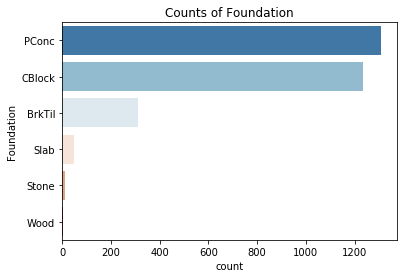

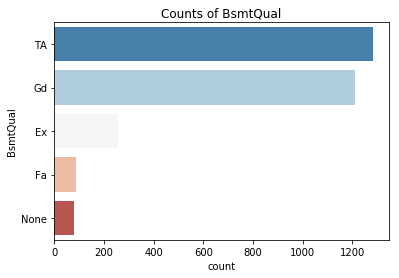

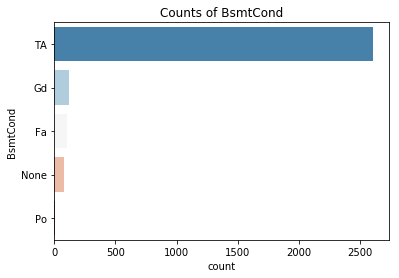

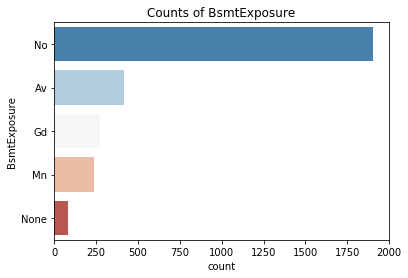

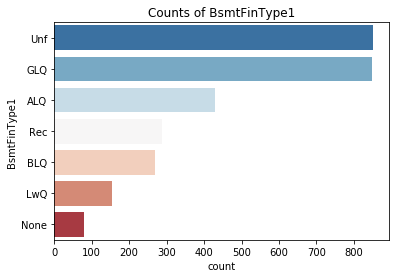

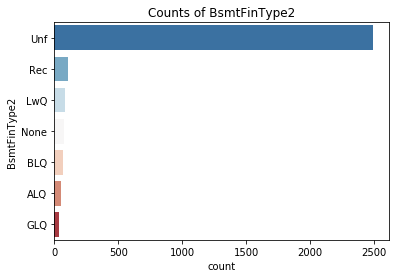

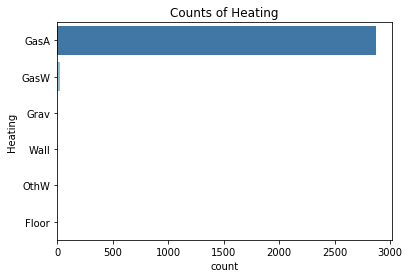

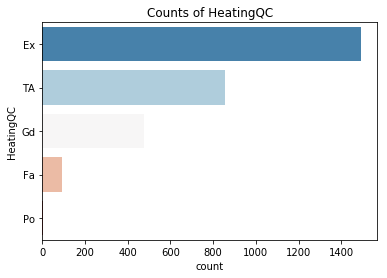

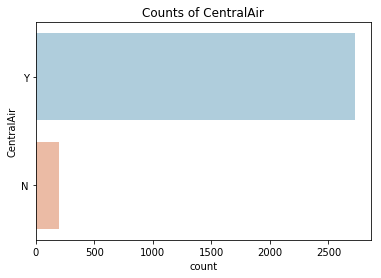

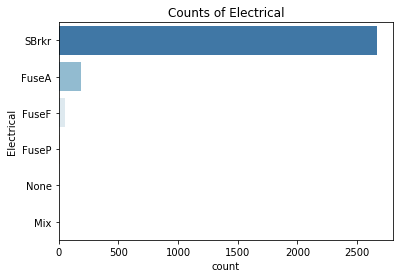

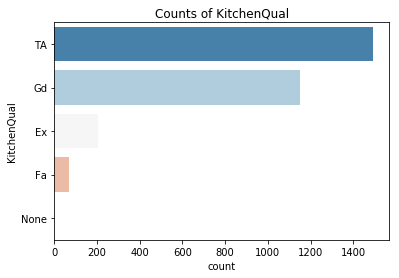

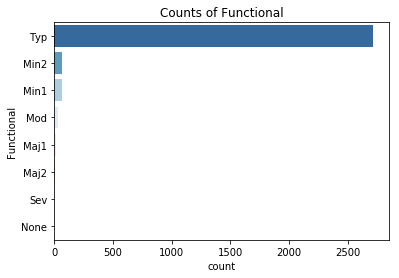

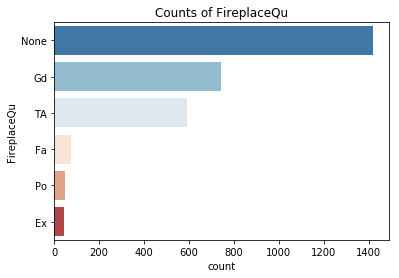

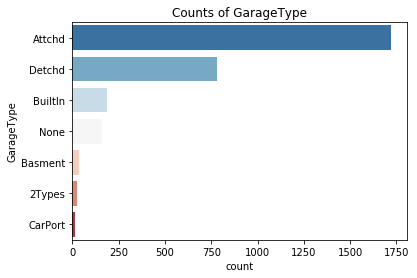

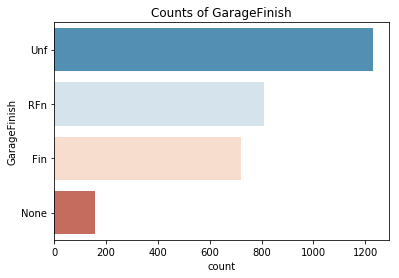

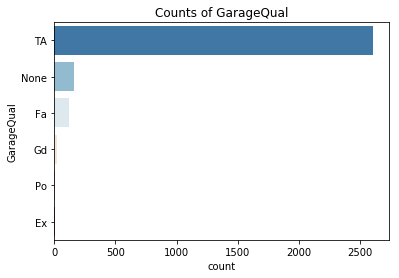

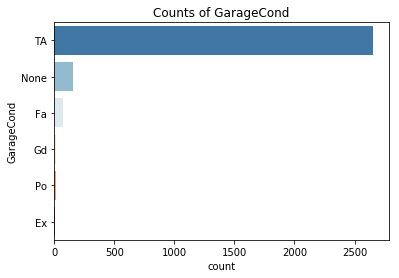

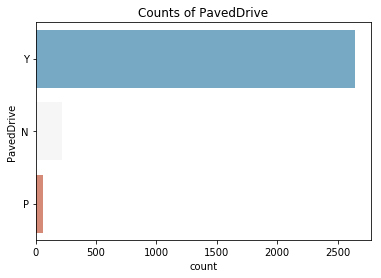

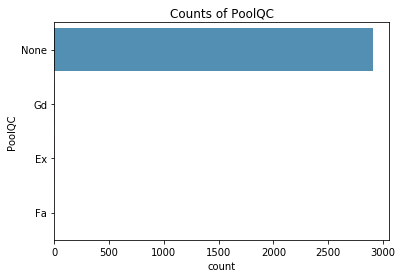

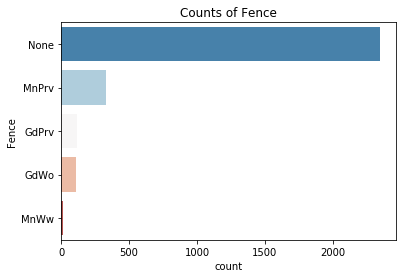

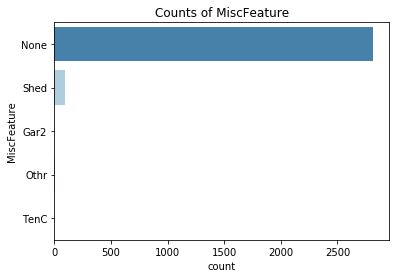

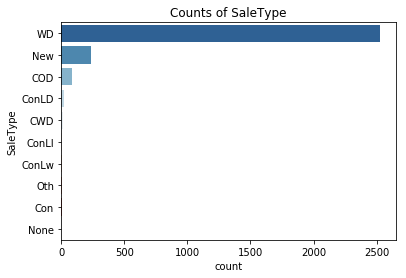

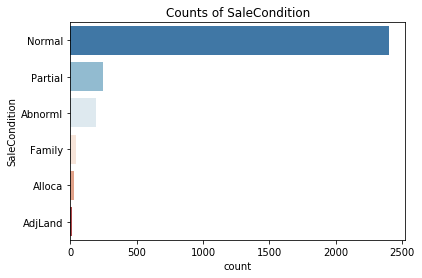

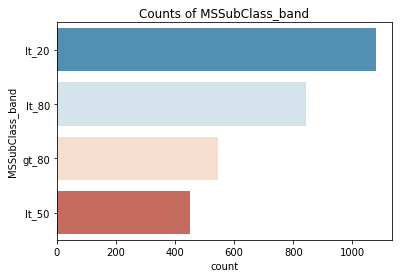

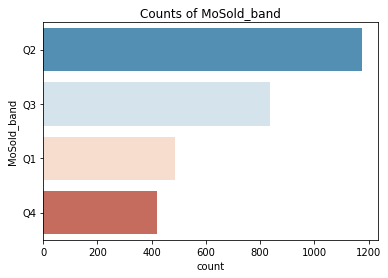

In [12]:
for i in range(0, len(CategoricalList)):
    df[CategoricalList[i]] = np.where(pd.isna(df[CategoricalList[i]]) == True, 'None', df[CategoricalList[i]])
    
for i in range(0, len(CategoricalList)):
    countplotshorizontal(frame = df, field = CategoricalList[i], title = "Counts of " + CategoricalList[i], ylabel = CategoricalList[i], palette = "RdBu_r")

#### If No Basement / Garage Present, Convert Related Continuous Variables to NaN

In [13]:
df['BsmtFinSF1'] = np.where(df['TotalBsmtSF'] == 0, np.nan, df['BsmtFinSF1'])
df['BsmtFinSF2'] = np.where(df['TotalBsmtSF'] == 0, np.nan, df['BsmtFinSF2'])
df['BsmtUnfSF'] = np.where(df['TotalBsmtSF'] == 0, np.nan, df['BsmtUnfSF'])
df['BsmtFullBath'] = np.where(df['TotalBsmtSF'] == 0, np.nan, df['BsmtFullBath'])
df['BsmtHalfBath'] = np.where(df['TotalBsmtSF'] == 0, np.nan, df['BsmtHalfBath'])
df['TotalBsmtSF'] = np.where(df['TotalBsmtSF'] == 0, np.nan, df['TotalBsmtSF'])

df['GarageArea'] = np.where(df['GarageYrBlt'] == np.nan, np.nan, df['GarageArea'])
df['GarageYrBlt'] = np.where(df['GarageYrBlt'] == np.nan, np.nan, df['GarageYrBlt'])

In [14]:
### Continuous Variable Summary Statistics

pd.options.display.float_format = '{:,.2f}'.format
display(HTML(df.filter(ContinuousList, axis = 1).describe(percentiles = [.01,.05,.10,.25,.50,.75,.90,.95,.99]).to_html()))

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TotalSF
count,"2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,840.00","2,840.00","2,840.00","2,840.00","2,919.00","2,919.00","2,919.00","2,919.00","2,840.00","2,840.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,919.00","2,760.00","2,919.00","2,919.00"
mean,57.77,"10,168.11",6.09,5.56,101.40,453.55,50.94,576.17,"1,080.66","1,159.58",336.48,4.69,"1,500.76",0.44,0.06,1.57,0.38,2.86,1.04,6.45,0.60,1.77,472.71,93.71,47.49,23.10,2.60,16.06,2.25,50.83,"90,491.59",38.69,25.74,31.96,2.21,"2,547.48"
std,33.48,"7,887.00",1.41,1.11,178.85,455.83,171.31,435.46,410.35,392.36,428.70,46.40,506.05,0.53,0.25,0.55,0.50,0.82,0.21,1.57,0.65,0.76,215.54,126.53,67.58,64.24,25.19,56.18,35.66,567.40,"106,496.38",30.29,20.89,25.21,1.31,805.12
min,0.00,"1,300.00",1.00,1.00,0.00,0.00,0.00,0.00,105.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,334.00
1%,0.00,"1,680.00",3.00,3.00,0.00,0.00,0.00,0.00,384.00,520.00,0.00,0.00,675.42,0.00,0.00,1.00,0.00,1.00,1.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,1.00,1.00,0.00,"1,014.18"
5%,0.00,"3,182.00",4.00,4.00,0.00,0.00,0.00,0.00,546.00,665.90,0.00,0.00,861.00,0.00,0.00,1.00,0.00,2.00,1.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,3.00,3.00,0.00,"1,511.80"
10%,0.00,"4,922.40",5.00,5.00,0.00,0.00,0.00,95.00,650.90,744.80,0.00,0.00,923.80,0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1.00,240.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,3.80,4.00,0.00,"1,696.00"
25%,43.00,"7,478.00",5.00,5.00,0.00,0.00,0.00,240.00,811.75,876.00,0.00,0.00,"1,126.00",0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1.00,320.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9.00,6.00,8.00,1.00,"2,000.00"
50%,63.00,"9,453.00",6.00,5.00,0.00,384.00,0.00,482.50,"1,004.00","1,082.00",0.00,0.00,"1,444.00",0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,2.00,480.00,0.00,26.00,0.00,0.00,0.00,0.00,0.00,"34,900.00",37.00,17.00,31.00,2.00,"2,448.00"
75%,78.00,"11,570.00",7.00,6.00,163.50,741.25,0.00,815.00,"1,313.00","1,387.50",704.00,0.00,"1,743.50",1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,2.00,576.00,168.00,70.00,0.00,0.00,0.00,0.00,0.00,"163,000.00",56.50,45.00,50.00,3.00,"2,991.50"


### View Histograms

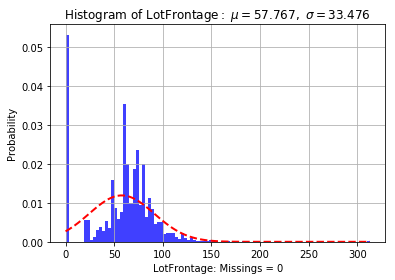

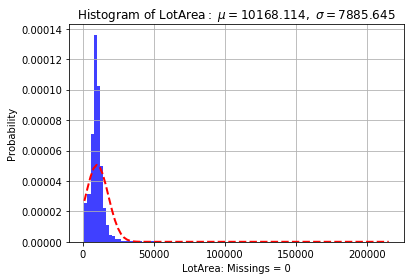

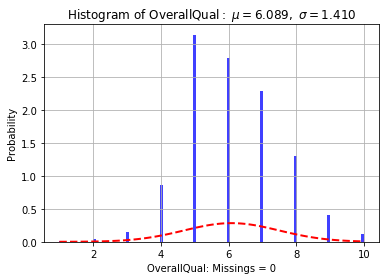

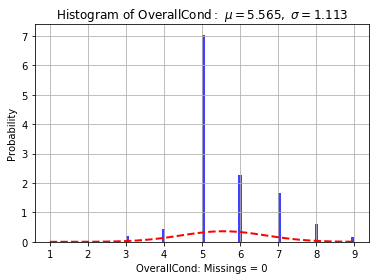

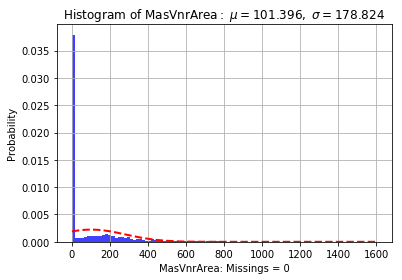

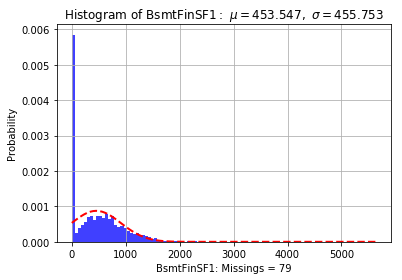

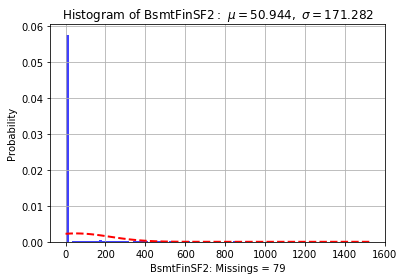

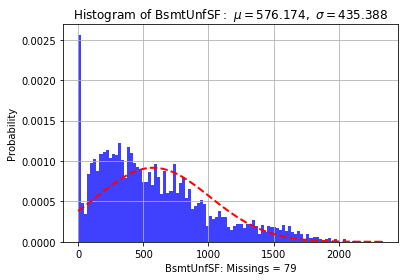

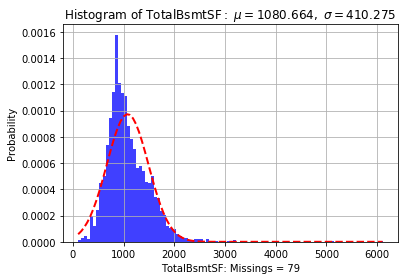

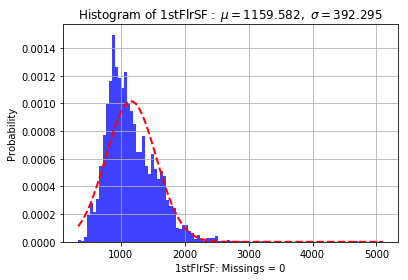

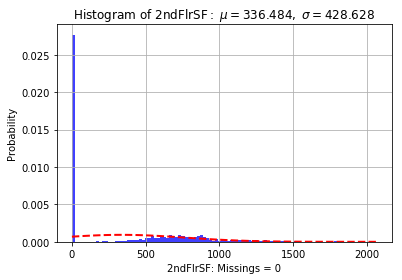

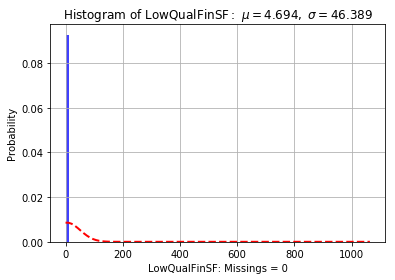

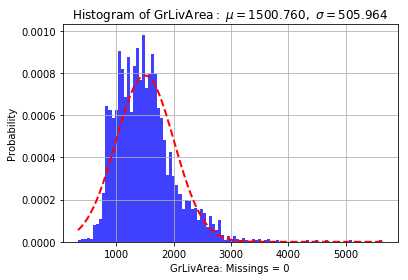

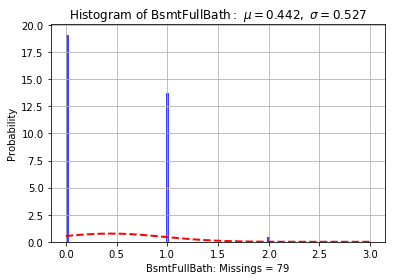

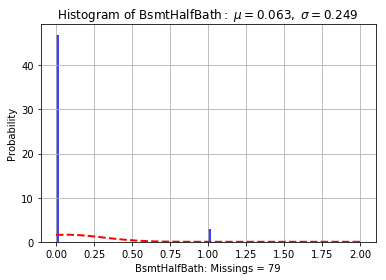

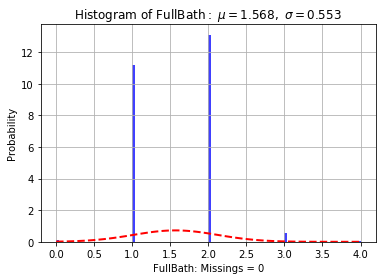

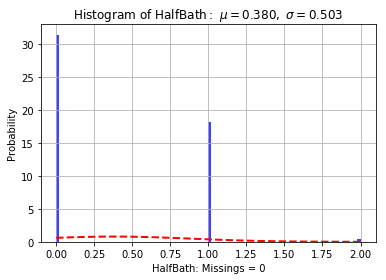

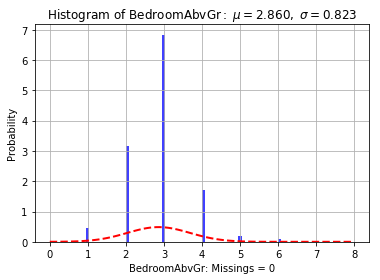

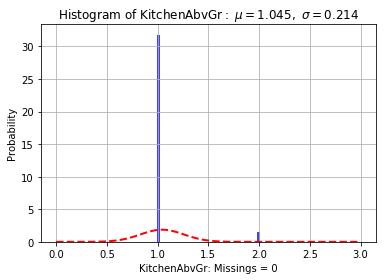

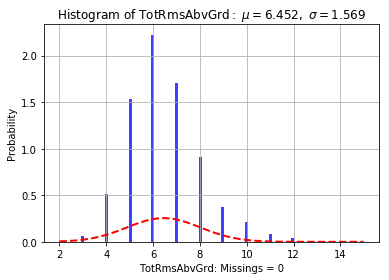

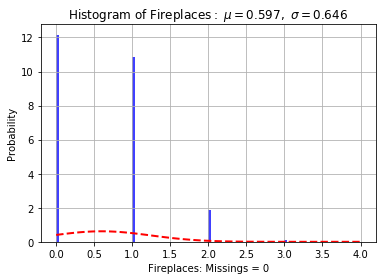

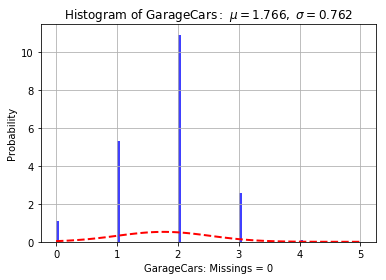

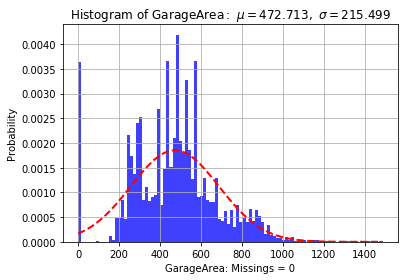

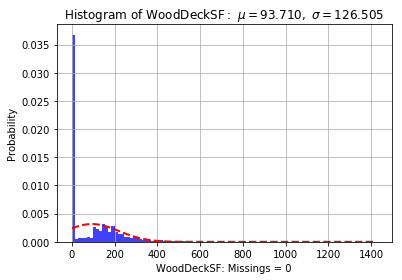

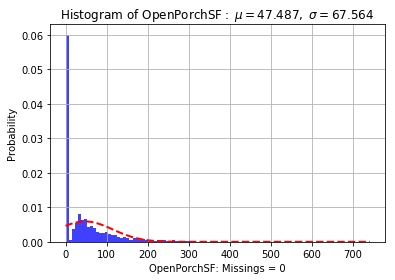

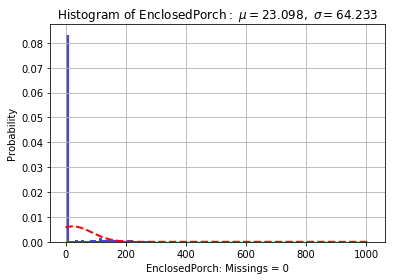

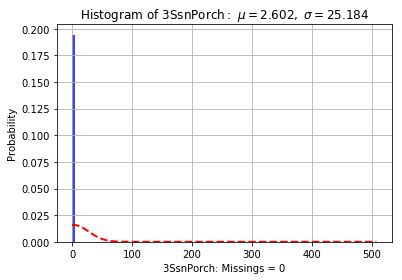

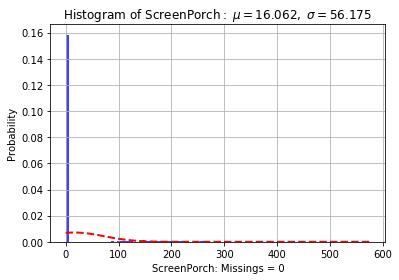

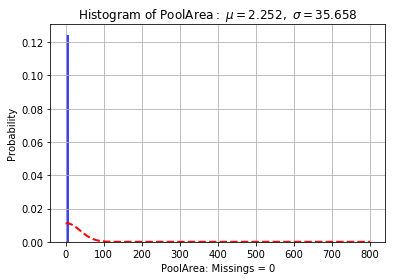

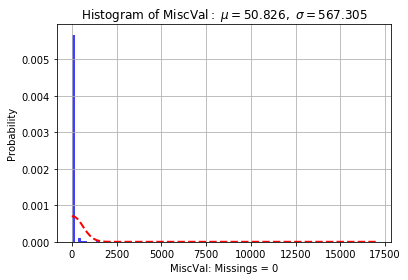

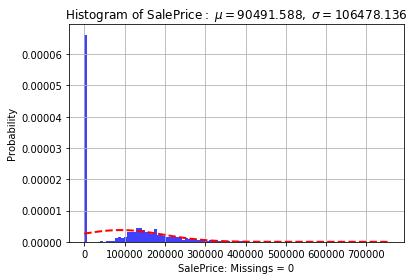

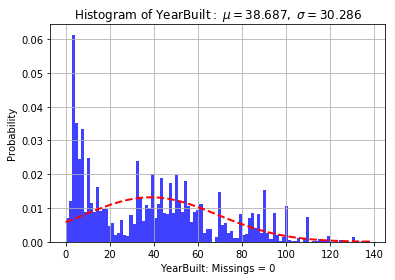

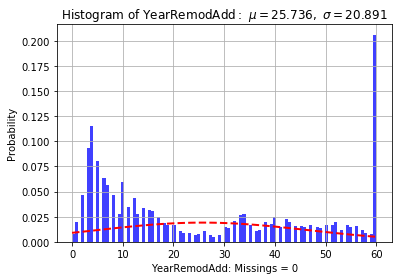

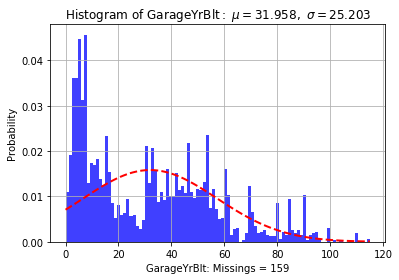

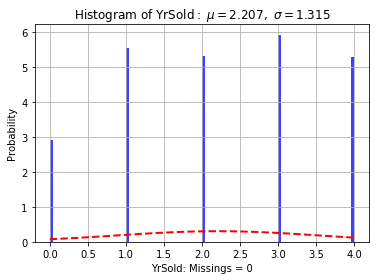

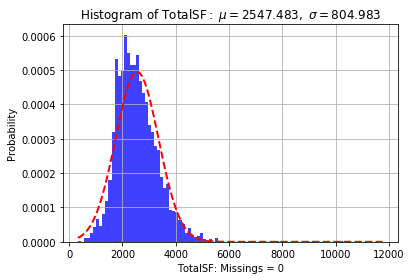

In [15]:
for i in range(0, len(ContinuousList)):
    histogram(df[ContinuousList[i]], ContinuousList[i], 'blue', 100)

### For the Columns with Zeros Where No Data Should be Missing, Impute Inserting Median Value of Neighborhood

In [16]:
# Group by neighborhood and fill in missing value by the median of all the neighborhood

ImputeList = ['LotFrontage']
 
for i in range(0,len(ImputeList)):
    df[ImputeList[i]] = df[ImputeList[i]].fillna(df.groupby('Neighborhood')[ImputeList[i]].median())

### Explore Correlation of Continuous Variables

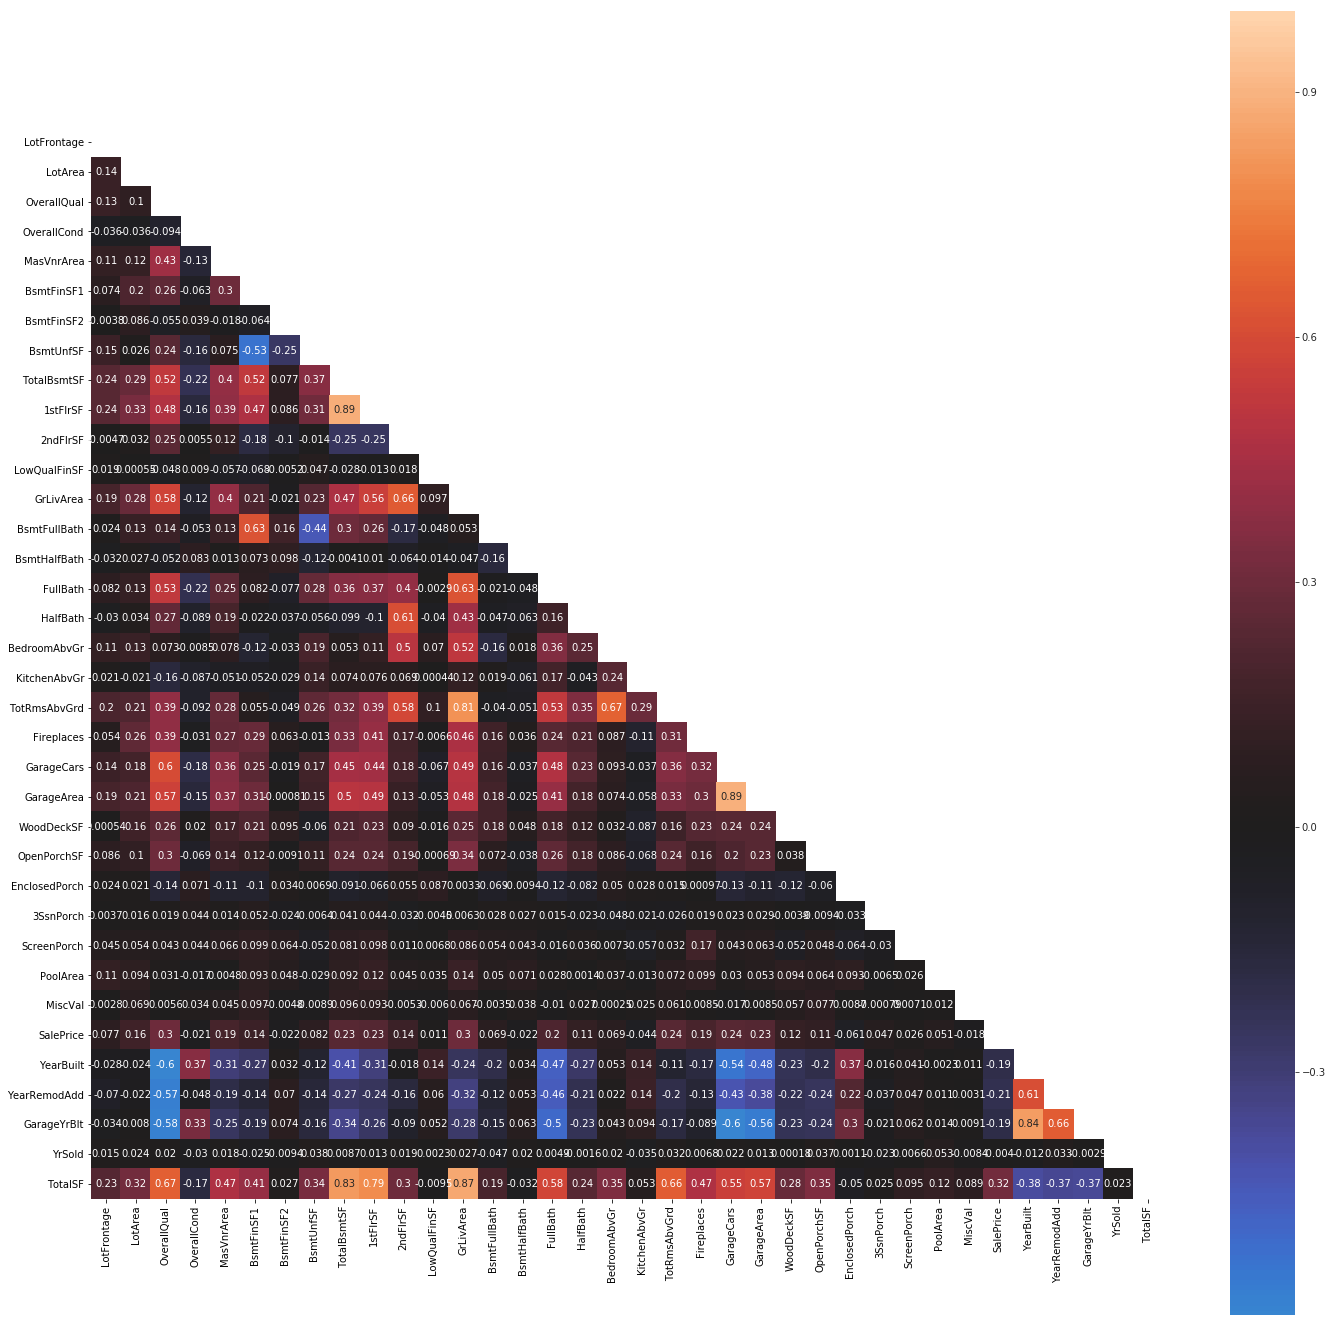

In [17]:
corr = df[ContinuousList].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(24, 24))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=1, center=0, square=True, annot=True)

In [18]:
idList = ['Id','segment']

TotalList = idList + ContinuousList + CategoricalList

df_all = df[TotalList].copy(deep = True)

display(HTML(df_all[0:5].to_html()))

,Id,segment,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TotalSF,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass_band,MoSold_band
0,1461,test,80,11622,5,6,0,468.00,144.00,270.00,882.00,896,0,0,896,0.00,0.00,1,0,2,1,5,0,1,730.00,140,0,0,0,120,0,0,0,49.00,49.00,49.00,0.00,1778,RH,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,Rec,LwQ,GasA,TA,Y,SBrkr,TA,Typ,None,Attchd,Unf,TA,TA,Y,None,MnPrv,None,WD,Normal,lt_20,Q2
1,1462,test,81,14267,6,6,108,923.00,0.00,406.00,"1,329.00",1329,0,0,1329,0.00,0.00,1,1,3,1,6,0,1,312.00,393,36,0,0,0,0,12500,0,52.00,52.00,52.00,0.00,2658,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,None,Attchd,Unf,TA,TA,Y,None,None,Gar2,WD,Normal,lt_20,Q2
2,1463,test,74,13830,5,5,0,791.00,0.00,137.00,928.00,928,701,0,1629,0.00,0.00,2,1,3,1,6,1,2,482.00,212,34,0,0,0,0,0,0,13.00,12.00,13.00,0.00,2557,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,None,MnPrv,None,WD,Normal,lt_80,Q1
3,1464,test,78,9978,6,6,20,602.00,0.00,324.00,926.00,926,678,0,1604,0.00,0.00,2,1,3,1,7,1,2,470.00,360,36,0,0,0,0,0,0,12.00,12.00,12.00,0.00,2530,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,Fin,TA,TA,Y,None,None,None,WD,Normal,lt_80,Q2
4,1465,test,43,5005,8,5,0,263.00,0.00,"1,017.00","1,280.00",1280,0,0,1280,0.00,0.00,2,0,2,1,5,0,2,506.00,0,82,0,0,144,0,0,0,18.00,18.00,18.00,0.00,2560,RL,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,Gable,CompShg,HdBoard,HdBoard,None,Gd,TA,PConc,Gd,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal,gt_80,Q1


### View Sales Price Boxplots by Each Category

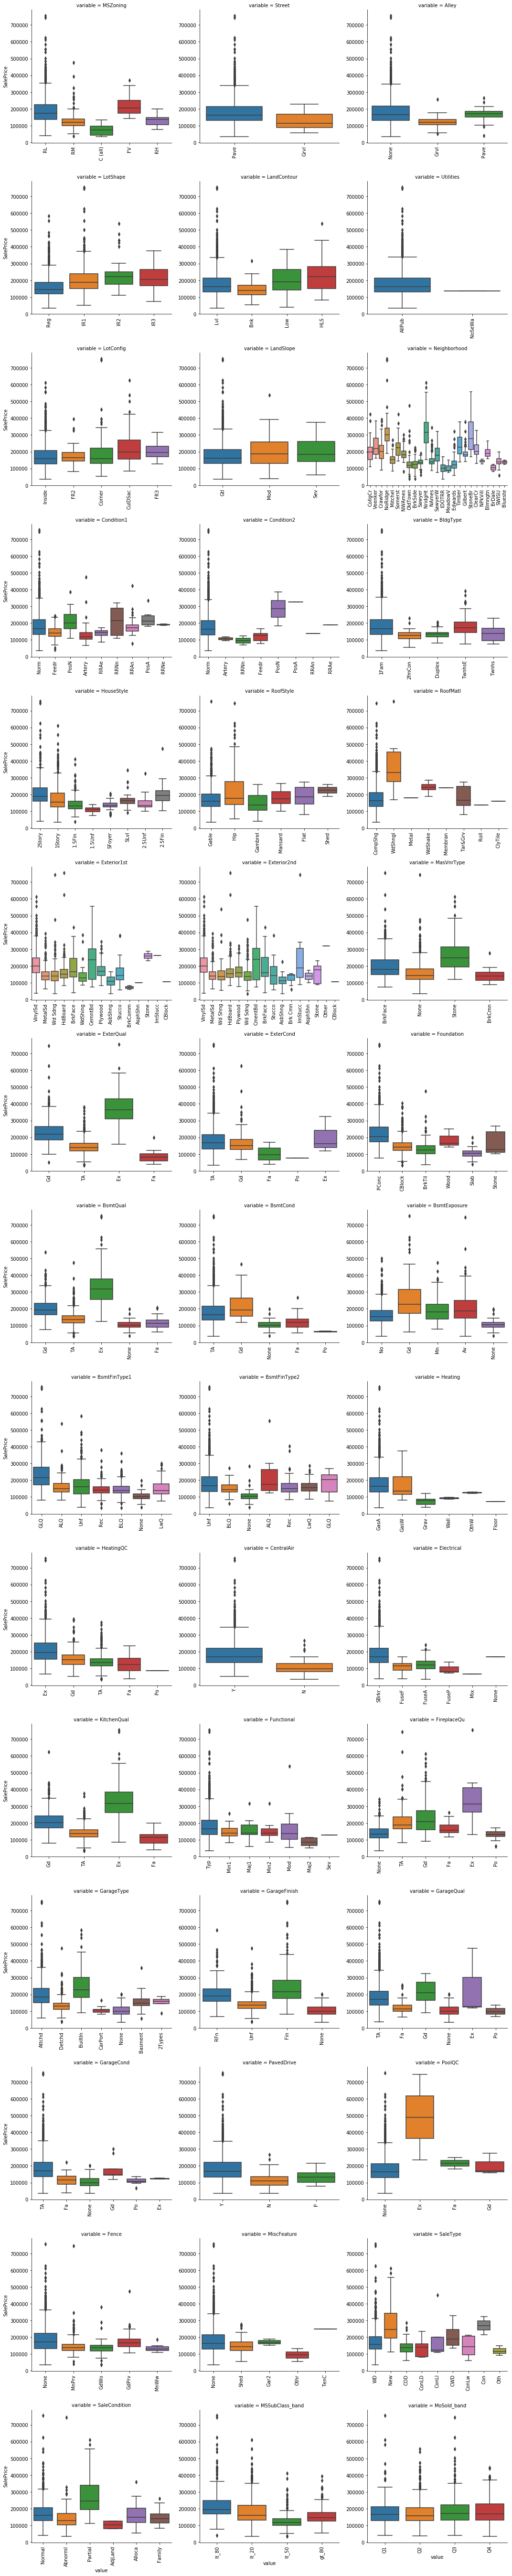

In [19]:
df_train = df_all[df_all['segment'] == 'train']
        
f = pd.melt(df_train, id_vars = ['SalePrice'], value_vars = CategoricalList)
g = sns.FacetGrid(f, col = "variable",  col_wrap = 3, sharex = False, sharey = False, height = 5)
g = g.map(boxplot, "value", "SalePrice")

### Box Plot Insight
* Collapsing Low Count Neighborhoods into "Other" Results in a Lot of Variance.  This may Cause an Issue Later, so Keep in Mind.
* "New" SaleType, "Excellent' KitchenQual, and "Partial" Sale Condition Push Up Sales Prices.

### Use Anova to Obtain Quick Estimates of Categorical Variables Impact on Sales Price.

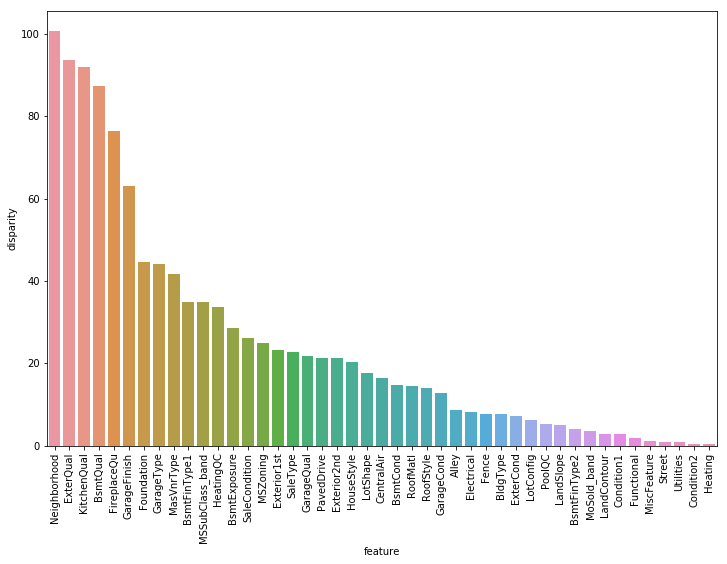

In [20]:
a = anova(frame = df_train, List = CategoricalList, target = 'SalePrice')

a['disparity'] = np.log(1. / a['pval'].values)
fig, ax = plt.subplots(figsize = (12, 8))
sns.barplot(data = a, x = 'feature', y = 'disparity', ax = ax)
x = plt.xticks(rotation = 90)

### Anova Insight
* Basement, Kitchen, and Exterior Quality have High Influence on Sales Price.

### Assess All Variables for Importance According to Spearman's Correlation
* Spearman correlation is better to work with in this case because it picks up relationships between variables even when they are nonlinear.

C:\Users\Armand\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Armand\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


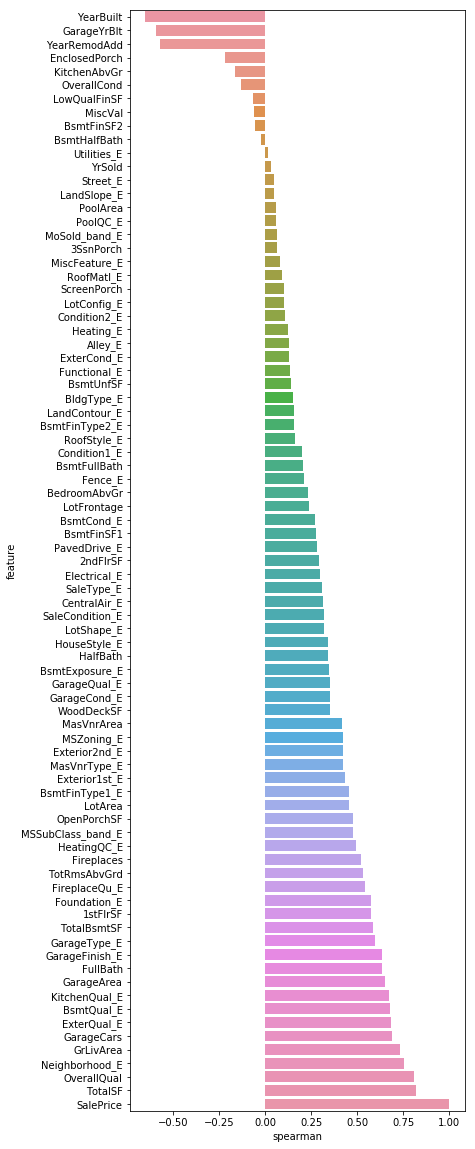

In [21]:
cat_encoded = []

for c in CategoricalList:  
    encode(frame = df_train, feature = c, target = 'SalePrice')
    cat_encoded.append(c + '_E')

features = ContinuousList + cat_encoded
spearman(df_train, features, target = 'SalePrice')

### Check Skewness

In [22]:
skewed_feats = df_train[ContinuousList].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)

skewness = pd.DataFrame({'Skew' :skewed_feats})

skewness = skewness[abs(skewness) > 1.00]
skewness = skewness.dropna(how = 'all')
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
print(skewness)

There are 19 skewed numerical features to Box Cox transform
               Skew
MiscVal       24.45
PoolArea      14.81
LotArea       12.20
3SsnPorch     10.29
LowQualFinSF  9.00 
KitchenAbvGr  4.48 
BsmtFinSF2    4.19 
ScreenPorch   4.12 
BsmtHalfBath  4.04 
EnclosedPorch 3.09 
MasVnrArea    2.67 
OpenPorchSF   2.36 
TotalBsmtSF   2.17 
SalePrice     1.88 
TotalSF       1.77 
BsmtFinSF1    1.67 
WoodDeckSF    1.54 
1stFlrSF      1.38 
GrLivArea     1.37 


#### Some Signficant Skew is Found.  All Variable Transformations Will Take Place in the Next Notebook (Feature Engineering).

In [23]:
# Save DataFrames

os.chdir(sys.path[0] + '\\Data')

# Convert These Lists to Dataframes Since it's Not Possible to Pickle Lists

df_categorical = pd.DataFrame(CategoricalList, columns = ['column'])
df_continuous = pd.DataFrame(ContinuousList, columns = ['column'])

df_all.to_pickle('df_all_1.pkl')

df_categorical.to_pickle('df_categorical_1.pkl')
df_continuous.to_pickle('df_continuous_1.pkl')

In [24]:
end_time = time.time()

diff = end_time - begin_time

print("run time ...", "\n")
print(diff, "seconds")
print(diff / 60, "minutes")
print(diff / 3600, "hours")

run time ... 

40.19107532501221 seconds
0.6698512554168701 minutes
0.011164187590281168 hours
